# Viscoelastic modeling

In this example, we show how to build the `SeisCL` object and how to call the program to build a viscoelastic model.

Let's examine the 3D isotropic viscoelatic medium. To solve the the heterogeneous wave equation, SeisCL uses multiple input files which respectively contains the simulation constants, the model parameters and the recorded data.

The first thing to do is to load the SeisCL class and relevant module:

In [1]:
from SeisCL import SeisCL
seis = SeisCL()
import numpy as np
import matplotlib.pyplot as plt

<!-- ## Simulation constants -->



### Simulation Domain

We can begin by setting up each of the simulation constants. They are stored in the dictionnary `seis.csts` which will later be written to disk. Reasonable defaults are available and the whole dictonnary can be accessed in the `SeisCL` class. Here we will only change the ones that are relevant for viscoelastic modeling, starting with the computational cell.

We're going to build a 3 dimensional cubic domain of size $ \small 600 \times 600 \times 600 \; (m) $ with a cell length of $ \small 2m$ in all directions with  $\small 800 \times 0.2ms $ time step for a total of $\small 0.16s $.



In [2]:
seis.csts['ND'] = 3                                 # Number of dimension
seis.csts['N'] = np.array([300, 300, 300])          # Grid size [NZ, NX, NY]
seis.csts['dt'] = dt = 0.25e-03                     # Time step size
seis.csts['dh'] = dh = 2                            # Grid spatial spacing
seis.csts['NT'] = NT = 800                          # Number of time steps
seis.csts['FDORDER'] = 4                            # Order of the finite difference

### Boundary layers

As for boundary conditions, we want to add absorbing boundaries around our domain.

Two absorbing boundary type are implemented : the convolutional perfectly matched layer (CPML) [Komatitsch and Martin (2007)](https://doi.org/10.1190/1.2757586) and the dissipative layer of [Cerjan, et al., 1985](https://doi.org/10.1190/1.1441945).

We choose here CPML by setting the flag `abs_type` to 1. We then set the width of the absorbing layer.

Importantly, the PML layer is overlapping the domain, which will be important for later steps. Its thickness is then set to reduce numerial reflections.

In [3]:
seis.csts['abs_type'] = 1               # Absorbing boundary type: 1: CPML, 2: Absorbing layer of Cerjan
seis.csts['nab'] = nab = 16             # Width in grid points of the absorbing layer

### Model parameters

The viscoelastic model used here is homogenous with $\small V_p = 3500 m/s$, $ \small V_s = 2000 m/s$, $ \small \rho = 2000 kg/m^3$. We set the attenuation levels to $ \small \tau_p = \tau_s = 0.1 \: dB/m$. A dictionnary is then created with those parameters in all 3 dimensions.

<br>

Simultanously we can set the center frequency of relaxation of the source to $ \small 20 \: Hz$, which will also be the central frequency of the attenuation mechanism.

<br>

Finally, note that by default the source is define as a ricker wavelet which is given by : $\normalsize \psi(t) = {2 \over {\sqrt {3\sigma}\pi^{1 \over 4}}} \left( 1 - {t^2 \over \sigma^2} \right) e^{-t^2 \over 2\sigma^2}$. 

In [4]:
vp = 3500
vs = 2000
rho = 2000
taup = 0.2
taus = 0.2

vp_a = np.zeros(seis.csts['N']) + vp
vs_a = np.zeros(seis.csts['N']) + vs
rho_a = np.zeros(seis.csts['N']) + rho
taup_a = np.zeros(seis.csts['N']) + taup
taus_a = np.zeros(seis.csts['N']) + taus

model_dict = {"vp": vp_a, "rho": rho_a, "vs": vs_a, "taup": taup_a, "taus": taus_a}


seis.csts['f0'] = f0 = 20 
seis.csts['FL'] = np.array([f0])
seis.csts['L'] = 1                  #Number of attenuation mechanism (L=0 elastic)


### Sources

Next we define geophones and source(s) positions. 

The source must be build in the `seis.src_pos_all` array, which has \[5 x number of sources\] dimensions and follows : 

 - Array \[sx sy sz srcid src_type\] x nb sources
 - srcid is the source number (same srcid are fired simulatneously)
 - src_type: 100: Explosive, 0: Force in X, 1: Force in Y, 2:Force in Z

The geophone/receivers are builded in `seis.rec_pos_all` and follows :

 - Position of the receivers. \[gx gy gz srcid recid - - -\] x nb receivers
 - srcid is the source number 
 - recid is the trace number in the record

As discutted earlier, since the PML layer is overlapping the domain, we must set a buffer zone between the layer and the geophone to ensure that the two won't interfer.

In [5]:
N = seis.csts['N'][0]
nbuf = seis.csts['FDORDER'] * 2

sx = (nab + nbuf) * dh
sy = N // 2 * dh
sz = N // 2 * dh
offmin = 5 * dh
offmax = (N - nab - nbuf) * dh - sx
gx = np.arange(sx + offmin, sx + offmax, dh)
gy = gx * 0 + N // 2 * dh
gz = gx * 0 + N // 2 * dh
offsets = gx-sx

seis.src_pos_all = np.stack([[sx], [sy], [sz], [0], [2]], axis=0)
gsid = np.zeros(np.shape(gx))
gid = np.arange(0, len(gz))


#Pourquoi les 3 dernières variables?
seis.rec_pos_all = np.stack([gx, gy, gz, gsid, gid, gx * 0 + 2,
                            gx * 0, gx * 0], axis=0)


### Simulation

Before launching the simulation, we will set up a last constant `seisout` which allows to decide what will be the output of SeisCL. Here we want the velocities of the model so we set the flag to 1.

`seis.set_forward` routine will then write constants, model and sources/receiver on disk.

Finally, `seis.execute()` will launch SeisCL.

In [6]:
seis.csts['seisout'] = 1
seis.set_forward(gsid, model_dict, withgrad=False)
seis.execute()
datafd = seis.read_data()
datafd = datafd[-1]

The result of SeisCL is a `.out` file which is read with `seis.read_data()`. Output data is a (NT, N-2*(nab-nbuf)) array which...  

### Analytic solution

We want to compare our finite difference solution to an analytical one. To solve analytically the viscoelastic wave propagation of a point source we will use the derivation of [Pilant (2012)](https://www.elsevier.com/books/elastic-waves-in-the-earth/pilant/978-0-444-41798-5) in the form given by [Gosselin-Cliche and Giroux (2014)](https://doi.org/10.1190/geo2013-0368.1). 


The implementation can be directly imported from the `analytical` module. (...) change `rec_pos`.


In [7]:
from analytical.viscoelastic import viscoelastic_3D, ricker_wavelet

src = ricker_wavelet(f0, 2*NT, dt)

rec_pos = []
for ii in range(0,len(gx)):
    rec_pos.append([offsets[ii], gy[ii]-sy, gz[ii]-sz])


analytic = viscoelastic_3D(vp, vs, rho, taup, taus,
                                   f0, seis.csts['FL'],
                                   dt, rec_pos, src)
analytic = analytic[-1][:NT, :]

### Visulization and comparaison

First, we normalise the finite difference and analytic solution. Then we can compare both solutions and the error.


In [8]:
datafd = datafd / np.sqrt(np.sum(datafd ** 2))
analytic = analytic / np.sqrt(np.sum(analytic ** 2))

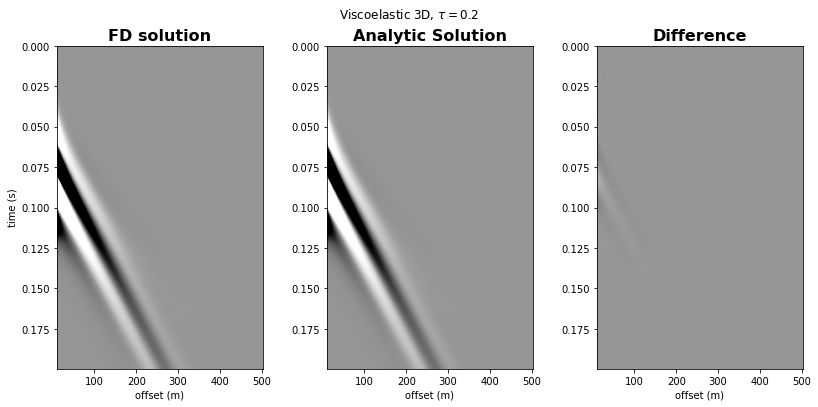

In [9]:
def compare_data(data_fd, analytic, offset, dt, testname):
    """
    Compare the analytical and finite difference solution.
    """
    err = np.sqrt(np.sum( (data_fd - analytic)**2) / np.sum(analytic**2))

    #Plot with shot fd, shot ana, diff
    clip = 0.1
    vmax = np.max(data_fd) * clip
    vmin = -vmax
    extent=[np.min(offset), np.max(offset), (data_fd.shape[0]-1)*dt, 0]
    fig, ax = plt.subplots(1, 3, figsize=[12, 6])
    plt.suptitle(testname)
    ax[0].imshow(data_fd, aspect='auto', vmax=vmax, vmin=vmin,
                 extent=extent, interpolation='bilinear',
                 cmap=plt.get_cmap('Greys'))
    ax[0].set_title("FD solution", fontsize=16, fontweight='bold')
    ax[0].set_xlabel("offset (m)")
    ax[0].set_ylabel("time (s)")
    ax[1].imshow(analytic, aspect='auto', vmax=vmax, vmin=vmin,
                 extent=extent, interpolation='bilinear',
                 cmap=plt.get_cmap('Greys'))
    ax[1].set_title("Analytic Solution", fontsize=16, fontweight='bold')
    ax[1].set_xlabel("offset (m)")
    ax[2].imshow(data_fd - analytic, aspect='auto', vmax=vmax, vmin=vmin,
                 extent=extent, interpolation='bilinear',
                 cmap=plt.get_cmap('Greys'))
    ax[2].set_title("Difference", fontsize=16, fontweight='bold')
    ax[2].set_xlabel("offset (m)")
    plt.tight_layout(h_pad=2, w_pad=2, pad=3)
    plt.show()

compare_data(datafd, analytic, offsets, dt, r'Viscoelastic 3D, $\tau = 0.2$')



## Elastic modeling

Once the first simulation is set up, we can easily change the parameters to vary the result. Here we show an elastic modelization.

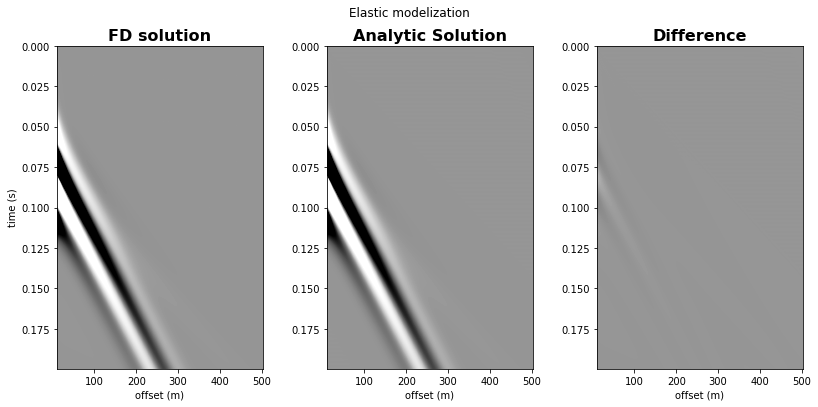

In [10]:
taup = 0
taus = 0

seis.csts['L'] = 0
seis.csts['FL'] = np.array([])

taup_a = np.zeros(seis.csts['N']) + taup
taus_a = np.zeros(seis.csts['N']) + taus

model_dict = {"vp": vp_a, "rho": rho_a, "vs": vs_a, "taup": taup_a, "taus": taus_a}

seis.set_forward(gsid, model_dict, withgrad=False)
seis.execute()
datafd = seis.read_data()
datafd = datafd[-1]

analytic = viscoelastic_3D(vp, vs, rho, taup, taus,
                                   f0, seis.csts['FL'],
                                   dt, rec_pos, src)

analytic = analytic[-1][:NT, :]
datafd = datafd / np.sqrt(np.sum(datafd ** 2))
analytic = analytic / np.sqrt(np.sum(analytic ** 2))

compare_data(datafd, analytic, offsets, dt, 'Elastic modelization')